In [1]:
import torch
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import trange
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import time
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import ScalarFormatter

In [2]:
def derivativespsi(X, T, psi):
    psi_real, psi_imag = psi.real, psi.imag  # Extract real & imaginary parts

    dpsi_dx_real, = torch.autograd.grad(psi_real, X, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dx_imag, = torch.autograd.grad(psi_imag, X, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dx = dpsi_dx_real + 1j * dpsi_dx_imag  # Reconstruct complex derivative

    dpsi_dx2_real, = torch.autograd.grad(dpsi_dx.real, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_real), 
                                         create_graph=True)
    dpsi_dx2_imag, = torch.autograd.grad(dpsi_dx.imag, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_imag), 
                                         create_graph=True)
    dpsi_dx2 = dpsi_dx2_real + 1j * dpsi_dx2_imag  # Reconstruct complex second derivative

    dpsi_dt_real, = torch.autograd.grad(psi_real, T, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dt_imag, = torch.autograd.grad(psi_imag, T, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dt = dpsi_dt_real + 1j * dpsi_dt_imag  # Reconstruct complex time derivative

    return dpsi_dt, dpsi_dx2

## Coherent state of the quantum harmonic oscillator

We modify the initial condition from a zero-centered ground state to a displaced Gaussian wavepacket centered at \( x_0 \). The initial wavefunction is:

$$
\psi_{\text{initial}}(x) = \pi^{-1/4} \exp\left(-\frac{(x - x_0)^2}{2}\right)
$$

The time-dependent coherent state solution contains:

1. **Spatial displacement**:
   $$ \xi(x,t) = x - x_0\cos(\omega t) $$
   representing the classical oscillation of the wavepacket center.

2. **Dynamic phase structure**:
   $$ \phi(x,t) = - x_0x\sin t + \frac{x_0^2}{4}\sin(2t) - \frac{t}{2} $$
   where:
   - The $-x_0x\sin t$ term provides the momentum kick
   - The $\frac{x_0^2}{4}\sin(2t)$ term maintains minimal uncertainty
   - The $-\frac{t}{2}$ term is the zero-point energy phase
   
Expected behavior:
1. The wavepacket oscillates with period $ T = 2\pi/\omega $ while maintaining its Gaussian shape
2. The center follows classical harmonic motion: $ x_{\text{center}}(t) = x_0\cos(\omega t) $
3. The width remains constant (no dispersion, characteristic of coherent states)
4. The maximum probability density stays fixed at $ 1/\sqrt{\pi} $


### Expectation Value of Position in Coherent States

The initial displaced Gaussian wavefunction is:

$$
\psi_0(x) = \pi^{-1/4} \exp\left(-\frac{(x - x_0)^2}{2}\right)
$$

where:
- $x_0$ is the initial displacement
- The width $\sigma = 1$ (natural units)

#### Analytical Solution for $\langle x \rangle$

For a harmonic oscillator ($\omega = 1$), the expectation value evolves as:

$$
\langle x \rangle_{\text{analytic}}(t) = x_0 \cos t
$$

#### Numerical Calculation of $\langle x \rangle$

The expectation value is computed numerically as:

$$
\langle x \rangle_{\text{num}}(t) = \int x |\psi(x,t)|^2 dx \approx \sum_i x_i |\psi(x_i,t)|^2 \Delta x
$$

where:
- $x_i$ are the spatial grid points
- $\Delta x$ is the grid spacing
- $|\psi(x_i,t)|^2$ is the probability density

Key properties:
1. **Oscillation**:
   - Amplitude: $x_0$ (both analytic and numerical)
   - Period: $2\pi$ (for $\omega=1$)
   
2. **Classical correspondence**:
   Both solutions match $x_{\text{cl}}(t) = x_0 \cos t$

3. **Implementation notes**:
   - The numerical integral uses trapezoidal rule
   - Should converge to analytic solution as $\Delta x \to 0$
   - Comparison metric: $|\langle x \rangle_{\text{num}} - \langle x \rangle_{\text{analytic}}|$

4. **Special cases**:
   - $t=0$: $\langle x \rangle = x_0$
   - $t=\pi/2$: $\langle x \rangle = 0$
   - $t=\pi$: $\langle x \rangle = -x_0$

### Expectation Value of Momentum in Coherent States

#### Analytical Solution for $\langle p \rangle$

For a harmonic oscillator ($\omega = 1$) with initial displacement $x_0$, the momentum expectation evolves as:

$$
\langle p \rangle_{\text{analytic}}(t) = -x_0 \sin t
$$

#### Numerical Calculation of $\langle p \rangle$

The expectation value is computed numerically via:

$$
\langle p \rangle_{\text{num}}(t) = \int \psi^*(x,t) \left(-i\frac{\partial}{\partial x}\right) \psi(x,t) \, dx \approx \text{Re}\left[\sum_i \psi_i^* (-i \Delta\psi_i) \Delta x\right]
$$

where:
- $\psi_i \equiv \psi(x_i,t)$
- $\Delta\psi_i$ is the spatial derivative approximation
- $\Delta x$ is the grid spacing

Key properties:
1. **Oscillation**:
   - Amplitude: $x_0$ (both solutions)
   - Phase: Leads $\langle x \rangle$ by $\pi/2$
   - Period: $2\pi$ (for $\omega=1$)

2. **Implementation notes**:
   - Uses automatic differentiation for $\partial_x \psi$
   - Takes real part to remove numerical imaginary components
   - Comparison metric: $|\langle p \rangle_{\text{num}} - \langle p \rangle_{\text{analytic}}|$

3. **Special cases**:
   - $t=0$: $\langle p \rangle = 0$ (starting from rest)
   - $t=\pi/2$: $\langle p \rangle = -x_0$ (maximum momentum)
   - $t=\pi$: $\langle p \rangle = 0$

4. **Consistency check**:
   Satisfies $\frac{d}{dt}\langle x \rangle = \langle p \rangle$ (Ehrenfest theorem)

### Energy Expectation in Coherent States

#### Analytical Solution

For a coherent state with initial displacement $x_0$ in a harmonic oscillator ($\omega=1$):

$$
E_{\text{analytic}} = \frac{x_0^2}{2} + \frac{1}{2}
$$

Where:
- $\frac{x_0^2}{2}$ = classical potential energy
- $\frac{1}{2}$ = zero-point energy

#### Numerical Calculation

The energy expectation is computed as:

$$
\langle H \rangle_{\text{num}}(t) = \int \psi^* H \psi \, dx
$$

Key properties:
1. **Constant energy**:
   - Should be time-independent for coherent states
   - Real part should dominate (imaginary part ≈ 0)

2. **Implementation notes**:
   - Uses second derivative $\partial_x^2 \psi$
   - Averages over spatial grid at each timestep
   - Comparison metric: $|\langle H \rangle_{\text{num}} - (\frac{x_0^2}{2} + \frac{1}{2})|$

3. **Special cases**:
   - $x_0 = 0$: $E = \frac{1}{2}$ (ground state)
   - $x_0 = 1$: $E = 1$


## Computational set-up

### Set-up for training

In this section, we define the spatial and temporal resolution (`Nx = 100`, `Nt = 100`), the number of training epochs (`100_000`), and the learning rate (`lr = 0.01`). These values correspond to those used in the coherent state results presented in the TFG.

You can modify any of these parameters manually below if you want to explore different resolutions or speed up training for testing purposes.

The code is set up to run on CPU by default. Change `'cpu'` to `'cuda'` if you want to train on a GPU and one is available.

In [3]:
# Hardware (CPU or GPU)
dev = 'cpu' # can be changed to 'cuda' for GPU usage
device = torch.device(dev)

# Network hyperparameters
Nin = 2   # Inputs to the neural network
Nout = 2  # Outputs of the neural network
Nhid1 = 40  # Nodes in the hidden layer
Nhid2 = 40  # Nodes in the hidden layer

# Network parameters
seed = 1
torch.manual_seed(seed)

# Layer 1 parameters (input -> hidden1)
W1 = torch.rand(Nhid1, Nin, requires_grad=True) * (-1.)       # [-1, 0] range, shape (Nhid1, Nin)
B1 = torch.rand(Nhid1, requires_grad=True) * 2. - 1.          # [-1, 1] range, shape (Nhid1,)

# Layer 2 parameters (hidden1 -> hidden2)
W2 = torch.rand(Nhid2, Nhid1, requires_grad=True) * 2. - 1.   # [-1, 1] range, shape (Nhid2, Nhid1)
B2 = torch.rand(Nhid2, requires_grad=True) * 1. - 0.5         # [-0.5, 0.5] range, shape (Nhid2,)

# Layer 3 parameters (hidden2 -> output)
W3 = torch.rand(Nout, Nhid2, requires_grad=True)              # [0, 1] range, shape (Nout, Nhid2)
B3 = torch.rand(Nout, requires_grad=True) * 0.4 - 0.2         # [-0.2, 0.2] range, shape (Nout,)
# Training hyperparameters
epochs = 100000
lr = 0.01  # Learning rate

# Mesh parameters
# For x
Nx = 100                    # Mesh division
train_ax = -4                      # Mesh lower limit
train_bx = 4                       # Mesh upper limit
x_train = torch.linspace(train_ax, train_bx, Nx, requires_grad=True, device=device) 

#For t
Nt = 50                    # Mesh division
train_at = 0                      # Mesh lower limit
train_bt = 2*np.pi                     # Mesh upper limit

t_train = torch.linspace(train_at, train_bt, Nt, requires_grad=True, device=device)

# Create 2D mesh grids
XT_train = torch.meshgrid(x_train, t_train, indexing="ij")  # Shape (Nx, Nt)



X = XT_train[0].reshape(-1, 1).to(device)
T = XT_train[1].reshape(-1, 1).to(device)

X = X.requires_grad_(True).to(device)  # Enable gradient tracking for X
T = T.requires_grad_(True).to(device)  # Enable gradient tracking for T

XT_train = torch.stack([X, T], dim=-1).reshape(-1, 2) # Shape (Nx * Nt, 2)

### Neural network architecture

We define a fully connected neural network with two inputs (space and time) and two outputs: the logarithm of the wavefunction’s magnitude and its phase. This allows us to model the complex-valued solution using only real-valued outputs.

In [4]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B1, W2, B2, W3=None, B3=None):
        super(HarmonicNQS, self).__init__()
        self.lc1 = nn.Linear(Nin, Nhid1, bias=True)
        self.actfun1 = nn.Sigmoid()
        self.lc2 = nn.Linear(Nhid1, Nhid2, bias=True)
        self.actfun2 = nn.Tanh()
        self.lc3 = nn.Linear(Nhid2, Nout, bias=True)
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B1)
            self.lc2.weight = nn.Parameter(W2)
            self.lc2.bias = nn.Parameter(B2)
            if W3 is not None and B3 is not None:
                self.lc3.weight = nn.Parameter(W3)
                self.lc3.bias = nn.Parameter(B3)
    def forward(self, x):
        h1 = self.actfun1(self.lc1(x))
        h2 = self.actfun2(self.lc2(h1))
        return self.lc3(h2)


### Learning rate scheduler

To improve convergence, we apply a `StepLR` scheduler which halves the learning rate every `10_000` epochs.

This means the initial learning rate of `0.01` becomes `0.005` at epoch 10_000, `0.0025` at epoch 20_000, and so on. This schedule was shown to accelerate training and stabilise loss descent.

In [5]:
# Initialize and compile network
net = HarmonicNQS(W1, B1, W2, B2)

# Define optimizer
#optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=lr
)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.5)

In [6]:
print("NN architecture:\n", net)

NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=2, out_features=40, bias=True)
  (actfun1): Sigmoid()
  (lc2): Linear(in_features=40, out_features=40, bias=True)
  (actfun2): Tanh()
  (lc3): Linear(in_features=40, out_features=2, bias=True)
)


### Loss function

The loss includes contributions from the TDSE residual, initial condition, final condition and boundary conditions. These are weighted in the total loss using λ₁ and λ₂. You can find or adjust these weights directly in the training script.

In [9]:
def losswcd():
    ln_abs_psi = net(XT_train)[:,0].reshape(-1,1)  # Shape (Nx*Nt,1)
    phase = net(XT_train)[:,1].reshape(-1,1)       # Shape (Nx*Nt,1)
    psi = torch.exp(ln_abs_psi + 1j * phase)

    
    # Compute derivatives
    dpsi_dt, dpsi_dx2 = derivativespsi(X, T, psi)
    
    # Compute hamiltonian and loss
    H=-dpsi_dx2/2 + (X**2)/2 * psi
    loss=torch.abs(1j * dpsi_dt - H)**2
    loss=loss.mean()  # Sum for all x and t
    
    # Conditions
    
    # Initial condition: moving Gaussian centered at x0=0.5
    x0 = 0.5
    psiini = psi.resize(Nx, Nt)[:, 0]
    x1 = X.resize(Nx, Nt)[:, 0]

    ini = torch.abs(psiini - np.pi**(-1/4) * torch.exp(-(x1 - x0)**2 / 2))**2
    ini = ini.mean()
    
    # Final condition
    psifin = psi.resize(Nx, Nt)[:, 49]
    x2 = X.resize(Nx, Nt)[:, 49]

    fin = torch.abs(psifin + np.pi**(-1/4) * torch.exp(-(x2 - x0)**2 / 2))**2
    fin = fin.mean()
    
    psiabs=torch.abs(psi.resize(Nx, Nt))**2
    norm=torch.abs(psiabs.sum(dim=0)-1) # Normalization
    norm=norm.mean()
    
    edges=psiabs[-1,:]+psiabs[0,:] # Edges go to zero
    edges=edges.mean()
    
    
    lambda1=10
    lambda2=0
    lambda3=10
    total_loss=loss+lambda1*ini+lambda2*norm+lambda3*edges+lambda1*fin
    return total_loss, ln_abs_psi, phase, loss, ini, fin, edges

## Training

This section trains the PINN to model the coherent state. Training progress is printed every 250 epochs. You can adjust `epochs` or `plot_every` to suit your runtime constraints.

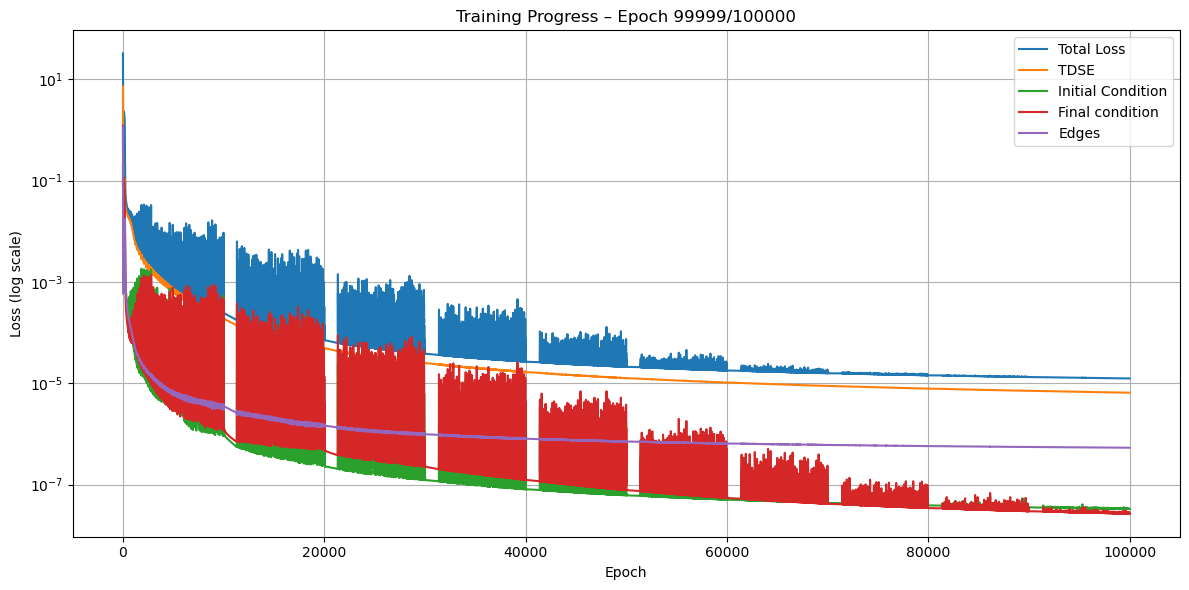


Training completed in 259.52 minutes


In [10]:
start_time = time.time()
plot_every = 250
losswcd_accum, TDSE_accum, ini_accum, norm_accum, edges_accum = [], [], [], [], []

# Training loop
for i in tqdm(range(epochs), desc="Epochs", leave=True):
    
    optimizer.zero_grad()
    losswcd0, ln_abs_psi, phase, TDSE, ini, norm, edges = losswcd()
    losswcd0.backward()
    optimizer.step()
    scheduler.step()
    
    # Record losses
    losswcd_accum.append(losswcd0.item())
    TDSE_accum.append(TDSE.item())
    ini_accum.append(ini.item())
    norm_accum.append(norm.item())
    edges_accum.append(edges.item())
    
    # Print learning rate every 251 iterations (as before)
    if i % 251 == 0 or i == epochs - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {i}: Learning Rate: {current_lr}")
    
    # Plotting (unchanged)
    if i % plot_every == 0 or i == epochs -1:
        clear_output(wait=False)
        plt.figure(figsize=(12,6))
        plt.plot(losswcd_accum, label="Total Loss")
        plt.plot(TDSE_accum, label="TDSE")
        plt.plot(ini_accum, label="Initial Condition")
        plt.plot(norm_accum, label="Final condition")
        plt.plot(edges_accum, label="Edges")
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (log scale)")
        plt.title(f"Training Progress – Epoch {i}/{epochs}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# Final timing summary
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

## Data

These cells compute all the data that will be needed later to evaluate the model:

In [11]:
def compute_wavefunction_grids(X, T, net, Nx, Nt, device):
    """
    Computes the wavefunction and its derivatives on a spatiotemporal grid.

    Parameters
    ----------
    X : torch.Tensor
        1D tensor of spatial coordinates (size Nx*Nt).
    T : torch.Tensor
        1D tensor of temporal coordinates (size Nx*Nt).
    net : torch.nn.Module
        Neural network model that outputs ln|ψ| and phase of ψ.
    Nx : int
        Number of spatial points.
    Nt : int
        Number of temporal points.
    device : torch.device
        Device to move tensors to (e.g. torch.device('cuda') or 'cpu').

    Returns
    -------
    dict
        Dictionary containing:
        - X_grid, T_grid: grid-shaped coordinate tensors
        - psi_grid: complex-valued ψ(x,t) on grid
        - dpsi_dx_grid: ∂ψ/∂x on grid
        - dpsi_dt_grid: ∂ψ/∂t on grid
        - dpsi_dx2_grid: ∂²ψ/∂x² on grid
    """
    X = X.requires_grad_(True).to(device).reshape(-1, 1)
    T = T.requires_grad_(True).to(device).reshape(-1, 1)
    XT = torch.cat([X, T], dim=1)

    ln_abs_psi = net(XT)[:, 0].reshape(-1, 1)
    phase = net(XT)[:, 1].reshape(-1, 1)
    psi = torch.exp(ln_abs_psi) * torch.exp(1j * phase)

    psi_real, psi_imag = psi.real, psi.imag

    # First and second derivatives
    dpsi_dt, dpsi_dx2 = derivativespsi(X, T, psi)

    dpsi_dx_real, = torch.autograd.grad(
        psi_real, X,
        grad_outputs=torch.ones_like(psi_real),
        create_graph=True
    )

    dpsi_dx_imag, = torch.autograd.grad(
        psi_imag, X,
        grad_outputs=torch.ones_like(psi_imag),
        create_graph=True
    )

    if dpsi_dx_real is None:
        dpsi_dx_real = torch.zeros_like(X)
    if dpsi_dx_imag is None:
        dpsi_dx_imag = torch.zeros_like(X)

    dpsi_dx = dpsi_dx_real + 1j * dpsi_dx_imag

    # Reshape to grid form (Nx, Nt)
    X_grid = X.view(Nx, Nt)
    T_grid = T.view(Nx, Nt)
    psi_grid = psi.view(Nx, Nt)
    dpsi_dx_grid = dpsi_dx.view(Nx, Nt)
    dpsi_dt_grid = dpsi_dt.view(Nx, Nt)
    dpsi_dx2_grid = dpsi_dx2.view(Nx, Nt)

    return {
        "X_grid": X_grid,
        "T_grid": T_grid,
        "psi_grid": psi_grid,
        "dpsi_dx_grid": dpsi_dx_grid,
        "dpsi_dt_grid": dpsi_dt_grid,
        "dpsi_dx2_grid": dpsi_dx2_grid
    }

In [12]:
grids = compute_wavefunction_grids(X, T, net, Nx, Nt, device)

X_grid = grids["X_grid"]
T_grid = grids["T_grid"]
psi_grid = grids["psi_grid"]
dpsi_dx_grid = grids["dpsi_dx_grid"]
dpsi_dt_grid = grids["dpsi_dt_grid"]
dpsi_dx2_grid = grids["dpsi_dx2_grid"]


In [54]:
def coherent_state_grid_from_mesh(X, T, x0):
    """
    Computes the coherent state wavefunction ψ(X, T) on a full spacetime grid,
    given meshgrid tensors X and T.

    Parameters:
        X (torch.Tensor): 2D tensor of shape (Nx, Nt), meshgrid of x values
        T (torch.Tensor): 2D tensor of shape (Nx, Nt), meshgrid of t values
        x0 (float): Coherent state initial displacement

    Returns:
        psi (torch.Tensor): Complex tensor of shape (Nx, Nt)
    """
    phase = - x0 * torch.sin(T) * X + 0.25 * x0**2 * torch.sin(2 * T) - 0.5 * T
    displacement = X - x0 * torch.cos(T)

    prefactor = (1 / np.pi**0.25)
    psi = prefactor * torch.exp(-0.5 * displacement**2 + 1j * phase)

    return psi

In [55]:
x0=0.5
psi_analy = coherent_state_grid_from_mesh(X_grid, T_grid, x0)

In [56]:
def compute_overlap(psi_nn, psi_analytic, X, T):
    """
    Computes the normalized overlap and fidelity between two wavefunctions
    on a spacetime grid defined by X and T.

    Parameters:
        psi_nn (torch.Tensor): Neural network wavefunction, shape (nx, nt), complex
        psi_analytic (torch.Tensor): Analytical wavefunction, shape (nx, nt), complex
        X (torch.Tensor): Spatial grid meshgrid, shape (nx, nt)
        T (torch.Tensor): Temporal grid meshgrid, shape (nx, nt)

    Returns:
        overlap (torch.Tensor): Complex normalized overlap
        fidelity (torch.Tensor): Real-valued fidelity (|overlap|^2)
    """
    # Compute step sizes assuming uniform grid
    dx = (X[1,0] - X[0,0]).item()
    dt = (T[0,1] - T[0,0]).item()

    integrand = torch.conj(psi_analytic) * psi_nn  # (nx, nt)
    inner_x = torch.trapz(integrand, dx=dx, dim=0)  # integrate over x → (nt,)
    inner_total = torch.trapz(inner_x, dx=dt, dim=0)  # integrate over t → scalar

    norm_nn = torch.trapz(torch.trapz(torch.abs(psi_nn)**2, dx=dx, dim=0), dx=dt, dim=0)
    norm_analytic = torch.trapz(torch.trapz(torch.abs(psi_analytic)**2, dx=dx, dim=0), dx=dt, dim=0)

    overlap = inner_total / torch.sqrt(norm_nn * norm_analytic)
    fidelity = torch.abs(overlap)**2

    return fidelity


In [57]:
overlap=compute_overlap(psi_grid, psi_analy, X_grid, T_grid)
overlap

tensor(1.0000, grad_fn=<PowBackward0>)

In [17]:
def calculate_total_energy(X, T, psi, dpsi_dx2):
    """
    Calculates total energy at every time step.

    Parameters:
        X (torch.Tensor): Spatial meshgrid (Nx, Nt)
        T (torch.Tensor): Time meshgrid (Nx, Nt)
        psi (torch.Tensor): Complex wavefunction (Nx, Nt)
        dpsi_dx2 (torch.Tensor): Second spatial derivative of psi (Nx, Nt)

    Returns:
        times_rescaled (np.ndarray): Time vector rescaled by 2π
        total_energy_np (np.ndarray): Total energy at each time step
    """
    dx = (X[1, 0] - X[0, 0]).item()

    kinetic_density = 0.5 * torch.real(torch.conj(psi) * (-dpsi_dx2))
    potential_density = 0.5 * (X ** 2) * torch.abs(psi) ** 2
    total_density = kinetic_density + potential_density

    kinetic_energy = torch.trapz(kinetic_density, dx=dx, dim=0)
    potential_energy = torch.trapz(potential_density, dx=dx, dim=0)
    total_energy = torch.trapz(total_density, dx=dx, dim=0)

    norm = torch.trapz(torch.abs(psi) ** 2, dx=dx, dim=0)
    total_energy /= norm

    times_np = T[0, :].detach().cpu().numpy()
    times_rescaled = times_np / (2 * np.pi)
    total_energy_np = np.abs(total_energy.detach().cpu().numpy())

    return times_rescaled, total_energy_np


In [18]:
times_rescaled, energy=calculate_total_energy(X_grid, T_grid, psi_grid, dpsi_dx2_grid)

## Visualisation of results

The following plots are used to evaluate the PINN’s performance in modelling the coherent state. Comparisons are made with the analytical solution where appropriate. All figures are saved in the following folder:

In [19]:
epochs = len(losswcd_accum)
x0=0.5
# === Create folder name ===
folder_name = f"{x0}_{epochs}_{lr}_{Nhid1}_{Nhid2}_{Nt}_2"
os.makedirs(folder_name, exist_ok=True)  # Create if not exists

### Training loss

This plot shows how the total loss and individual components (TDSE residual, initial condition, etc.) evolve over training. Use this to confirm convergence.

In [58]:


def plot_loss_components(epochs, losswcd_accum, TDSE_accum, ini_accum, norm_accum, edges_accum,
                         folder_name=None, title="loss_curve"):
    """
    Plots the different components of the loss over training epochs.

    Parameters:
        epochs (np.ndarray): Array of epoch indices
        losswcd_accum, TDSE_accum, ini_accum, norm_accum, edges_accum (np.ndarray): Loss components
        folder_name (str, optional): Folder for saving the figure
        title (str): Filename title (without extension)

    Returns:
        None
    """
    plt.rcParams.update({'font.size': 10})
    figsize = (5, 4)
    fig, ax = plt.subplots(figsize=figsize)

    # Distinguishable colors
    colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd']  # blue, red, green, orange, purple

    # Updated line styles
    # Total Loss, TDSE (dashed), Initial, Final, Edges (long dash)
    line_styles = ['-', (0, (5, 5)), '-', '-', (0, (5, 8))]

    # Data and labels
    losses = [losswcd_accum, TDSE_accum, ini_accum, norm_accum, edges_accum]
    labels = ['Total Loss', 'TDSE', 'Initial', 'Final', 'Edges']

    for i, (loss, label) in enumerate(zip(losses, labels)):
        ax.plot(
            epochs, loss, label=label,
            color=colors[i], lw=2, linestyle=line_styles[i],
            zorder=10 if label == 'TDSE' else 1  # TDSE on top
        )

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_yscale("log")
    ax.legend(fontsize=8)

    # Forcing ticks at 1e2 and 1e-8
    ax.set_ylim(1e-8, 1e2)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))
    ax.yaxis.set_minor_formatter(plt.NullFormatter())

    # Scientific notation for x-axis
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Match energy plot style
    ax.set_aspect(1. / ax.get_data_ratio())

    plt.tight_layout()

    if folder_name:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{title}.pdf", dpi=300)

    plt.show()
    plt.close()


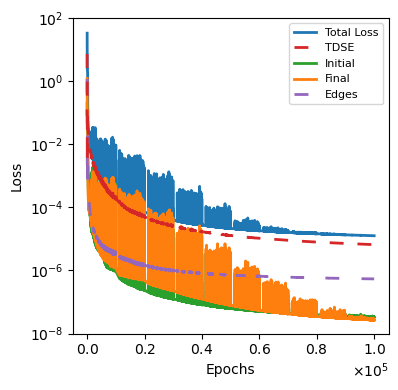

In [59]:
epochs = np.arange(len(losswcd_accum))
plot_loss_components(epochs, losswcd_accum, TDSE_accum, ini_accum, norm_accum, edges_accum, folder_name=folder_name)

### Wavefunction plots
Here are some plots to see how well our PINN predictions match out analytical ones

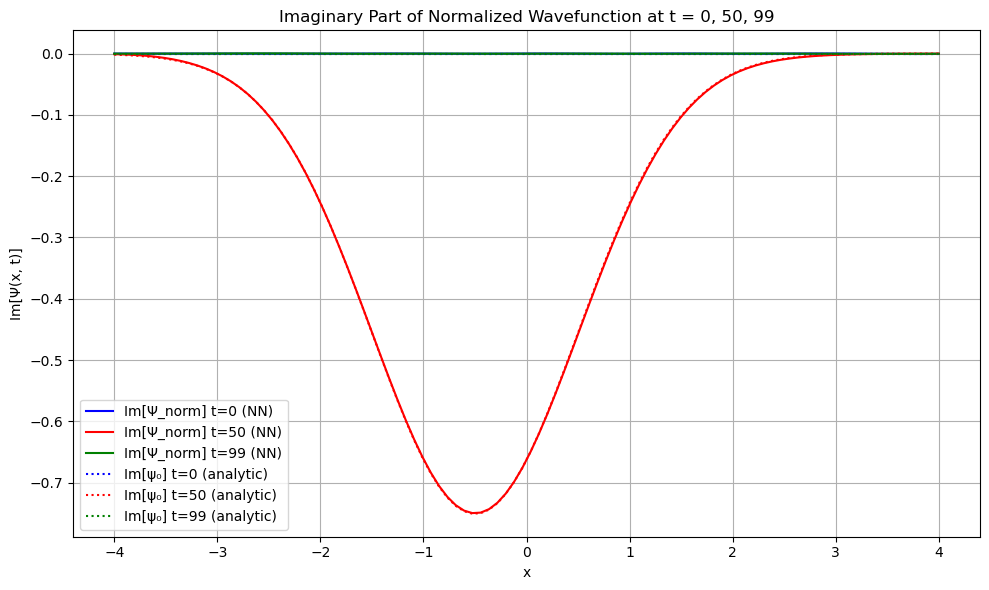

In [67]:
plt.figure(figsize=(10, 6))


# Imaginary part of the normalized wavefunction
psi_imag = psi_normalized.imag.detach()

# Plot imaginary parts from NN (normalized)
plt.plot(x_vals, psi_imag[:, 0].numpy(), label="Im[Ψ_norm] t=0 (NN)", color="blue")
plt.plot(x_vals, psi_imag[:, 50].numpy(), label="Im[Ψ_norm] t=50 (NN)", color="red")
plt.plot(x_vals, psi_imag[:, 99].numpy(), label="Im[Ψ_norm] t=99 (NN)", color="green")

# Plot imaginary parts from analytic solution
plt.plot(x_vals, psi0_t0.imag.detach().numpy(), ':', color='blue', label="Im[ψ₀] t=0 (analytic)")
plt.plot(x_vals, psi0_t50.imag.detach().numpy(), ':', color='red', label="Im[ψ₀] t=50 (analytic)")
plt.plot(x_vals, psi0_t99.imag.detach().numpy(), ':', color='green', label="Im[ψ₀] t=99 (analytic)")

# Plot decorations
plt.title("Imaginary Part of Normalized Wavefunction at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("Im[Ψ(x, t)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_imag_psi_normalized.png", dpi=300)
plt.show()
plt.close()

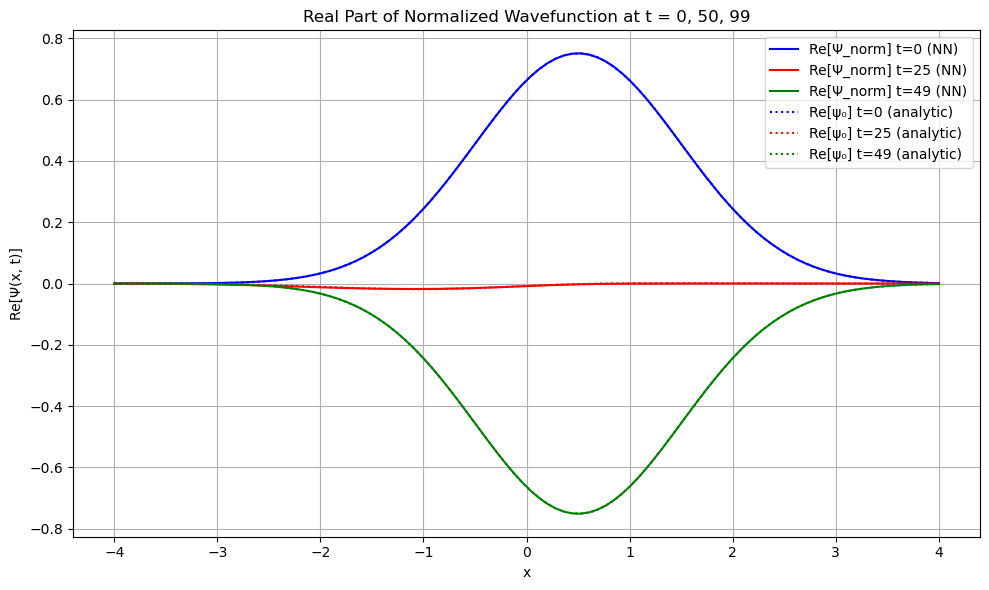

In [65]:

plt.figure(figsize=(10, 6))

dx = (train_bx - train_ax) / (Nx - 1)
norms = torch.sum(torch.abs(psi_grid)**2, dim=0, keepdim=True) * dx
psi_normalized = psi_grid / torch.sqrt(norms)

# x values for plotting
x_vals = X_grid[:, 0].detach().numpy()
psi_real = psi_normalized.real.detach()


# Compute analytic wavefunction at three times
psi0_t0 = psi_analy[:,0]
psi0_t50 = psi_analy[:,50]
psi0_t99 = psi_analy[:,99]


# --- Plotting ---
plt.plot(x_vals, psi_real[:, 0].numpy(), label="Re[Ψ_norm] t=0 (NN)", color="blue")
plt.plot(x_vals, psi_real[:, 50].numpy(), label="Re[Ψ_norm] t=25 (NN)", color="red")
plt.plot(x_vals, psi_real[:, 99].numpy(), label="Re[Ψ_norm] t=49 (NN)", color="green")

plt.plot(x_vals, psi0_t0.real.detach().numpy(), ':', color='blue', label="Re[ψ₀] t=0 (analytic)")
plt.plot(x_vals, psi0_t50.real.detach().numpy(), ':', color='red', label="Re[ψ₀] t=25 (analytic)")
plt.plot(x_vals, psi0_t99.real.detach().numpy(), ':', color='green', label="Re[ψ₀] t=49 (analytic)")

#plt.plot(x_vals, psi0_eff_t0.real.detach().numpy(), '--', color='cyan', label="Re[ψ₀] t=0 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t50.real.detach().numpy(), '--', color='magenta', label="Re[ψ₀] t=50 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t99.real.detach().numpy(), '--', color='orange', label="Re[ψ₀] t=99 (analytic, ω')")

plt.title("Real Part of Normalized Wavefunction at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("Re[Ψ(x, t)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_real_psi_normalized.png", dpi=300)
plt.show()
plt.close()


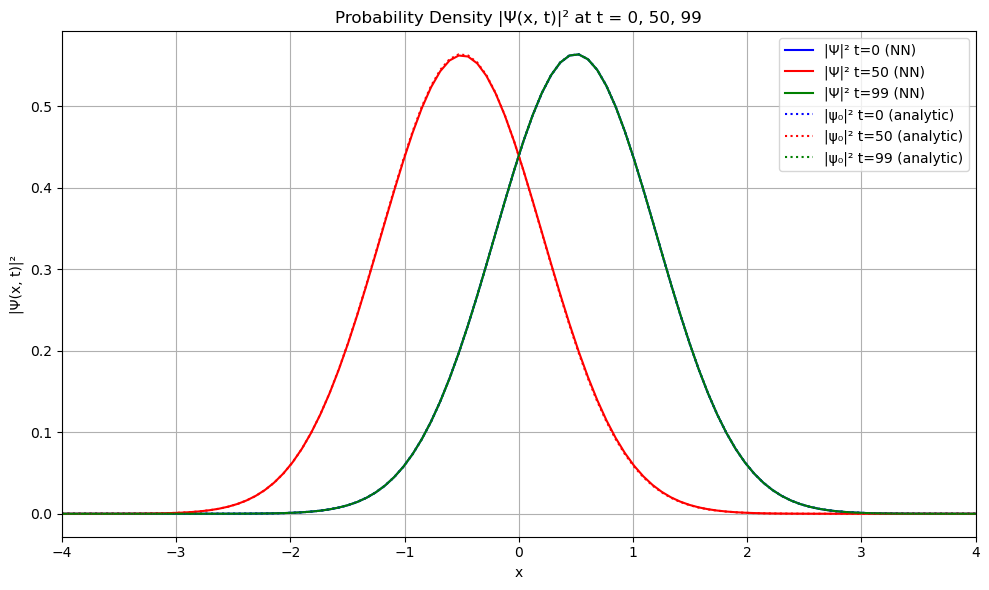

In [68]:
plt.figure(figsize=(10, 6))
psi_sq = torch.abs(psi_normalized)**2


plt.plot(x_vals, psi_sq[:, 0].detach().numpy(), label="|Ψ|² t=0 (NN)", color="blue")
plt.plot(x_vals, psi_sq[:, 50].detach().numpy(), label="|Ψ|² t=50 (NN)", color="red")
plt.plot(x_vals, psi_sq[:, 99].detach().numpy(), label="|Ψ|² t=99 (NN)", color="green")

plt.plot(x_vals, (torch.abs(psi0_t0)**2).detach().numpy(), ':', color="blue", label="|ψ₀|² t=0 (analytic)")
plt.plot(x_vals, (torch.abs(psi0_t50)**2).detach().numpy(), ':', color="red", label="|ψ₀|² t=50 (analytic)")
plt.plot(x_vals, (torch.abs(psi0_t99)**2).detach().numpy(), ':', color="green", label="|ψ₀|² t=99 (analytic)")

plt.title("Probability Density |Ψ(x, t)|² at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("|Ψ(x, t)|²")
plt.xlim(-4, 4)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_modulus_squared.png", dpi=300)
plt.show()
plt.close()

### Energy conservation

We plot the predicted kinetic and potential energies over time and compare them with the analytical values. The total energy should remain approximately constant.


In [69]:
def plot_energy_components(X, T, psi, dpsi_dx2, x0, folder_name=None, title="Energy_Components_Over_Time"):
    """
    Computes and plots the absolute total, kinetic, and potential energies over time.

    Parameters:
        X, T (torch.Tensor): Meshgrid tensors of shape (Nx, Nt)
        psi (torch.Tensor): Complex wavefunction on the meshgrid (Nx, Nt)
        dpsi_dx2 (torch.Tensor): Second spatial derivative of psi (Nx, Nt)
        x0 (float): Displacement of the coherent state
        folder_name (str, optional): Folder path for saving the plot
        title (str): Title of the filename (default "Energy_Components_Over_Time")

    Returns:
        mean_rel_error (float): Mean relative error of total energy
        max_rel_error (float): Max relative error of total energy
    """
    dx = (X[1, 0] - X[0, 0]).item()

    # Energy densities
    kinetic_density = 0.5 * torch.real(torch.conj(psi) * (-dpsi_dx2))
    potential_density = 0.5 * (X ** 2) * torch.abs(psi) ** 2
    total_density = kinetic_density + potential_density

    # Integrate over space
    kinetic_energy = torch.trapz(kinetic_density, dx=dx, dim=0)
    potential_energy = torch.trapz(potential_density, dx=dx, dim=0)
    total_energy = torch.trapz(total_density, dx=dx, dim=0)

    # Normalize
    norm = torch.trapz(torch.abs(psi) ** 2, dx=dx, dim=0)
    kinetic_energy /= norm
    potential_energy /= norm
    total_energy /= norm

    # Convert to NumPy
    times_np = T[0, :].detach().cpu().numpy()
    times_rescaled = times_np / (2 * np.pi)
    kinetic_np = kinetic_energy.detach().cpu().numpy()
    potential_np = potential_energy.detach().cpu().numpy()
    total_np = np.abs(total_energy.detach().cpu().numpy())

    # Analytical energy and relative errors
    analytical_E = x0 ** 2 / 2 + 0.5
    rel_errors = np.abs((total_np - analytical_E) / analytical_E)
    mean_rel_error = np.mean(rel_errors)
    max_rel_error = np.max(rel_errors)

    print(f"Mean relative error: {mean_rel_error:.3e}")
    print(f"Max relative error:  {max_rel_error:.3e}")

    # Use RdBu colormap for colors
    cmap = plt.get_cmap('RdBu')
    color_total = cmap(0.3)    # blue-ish
    color_kinetic = cmap(0.1)  # neutral-ish
    color_potential = cmap(0.9)  # red-ish
    color_analytical = "gray"

    # Plot
    plt.rcParams.update({'font.size': 10})
    figsize = (4, 4)
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(times_rescaled, total_np, label='Total', color=color_total, lw=2)
    plt.plot(times_rescaled, kinetic_np, label='Kinetic', color=color_kinetic)
    plt.plot(times_rescaled, potential_np, label='Potential', color=color_potential)
    plt.axhline(analytical_E, color=color_analytical, linestyle=':', label=f'Expected: {analytical_E:.3f}')

    ax.set_xlabel("$t$ $/$ $2\pi$ (cycles)")
    ax.set_ylabel("E (h.o units)")
    #ax.set_title(title.replace("_", " "))
    #ax.legend(loc='center right', bbox_to_anchor=(0.98, 0.6), fontsize=8)
    ax.legend()

    ax.set_aspect(1. / ax.get_data_ratio())
    plt.tight_layout()

    if folder_name:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{title}.pdf")

    plt.show()

    return mean_rel_error, max_rel_error

Mean relative error: 1.577e-03
Max relative error:  2.847e-03


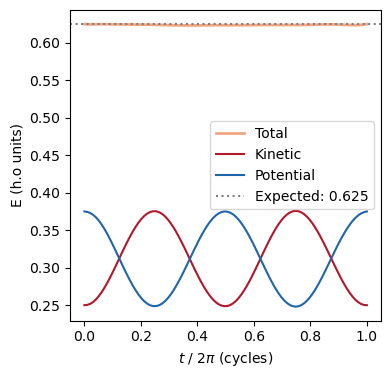

In [70]:
mean_rel_error, max_rel_error=plot_energy_components(X_grid, T_grid, psi_grid, dpsi_dx2_grid, x0, folder_name=folder_name)

### Expectation values ⟨x⟩ and ⟨p⟩

This figure compares the predicted ⟨x⟩ and ⟨p⟩ with the analytical expressions. The coherent state should oscillate sinusoidally in both position and momentum.


In [71]:
def plot_expectation_values(X, T, psi, dpsi_dx, x0, folder_name=None, title="expectation_values"):
    """
    Computes and plots the expectation values of position ⟨x⟩ and momentum ⟨p⟩ over time.

    Parameters:
        X, T (torch.Tensor): Meshgrid tensors of shape (Nx, Nt)
        psi (torch.Tensor): Complex wavefunction on the meshgrid (Nx, Nt)
        dpsi_dx (torch.Tensor): First spatial derivative of psi (Nx, Nt)
        x0 (float): Displacement of the coherent state
        folder_name (str): Folder path for saving the plot
        title (str): Base filename
    """
    dx = (X[1,0] - X[0,0]).item()
    t_train = T[0, :]

    density = torch.abs(psi)**2
    x_expectation = torch.trapz(X * density, dx=dx, dim=0)

    momentum_density = torch.conj(psi) * (-1j * dpsi_dx)
    p_expectation = torch.trapz(momentum_density, dx=dx, dim=0).real
    norm = torch.trapz(density, dx=dx, dim=0)
    p_expectation /= norm
    
    times = t_train.detach().cpu().numpy()
    times_rescaled = times / (2 * np.pi)
    x_expectation_np = x_expectation.detach().cpu().numpy()
    p_expectation_np = p_expectation.detach().cpu().numpy()

    x_analytic = x0 * np.cos(times)
    p_analytic = -x0 * np.sin(times)

    cmap = plt.get_cmap('RdBu')
    color_x = cmap(0.1)  # blue-ish
    color_p = cmap(0.9)  # red-ish
    color_analy = cmap(0.3) #orange-ish

    plt.figure(figsize=(4, 4))
    plt.plot(times_rescaled, x_expectation_np, label=r"$\langle x \rangle(t)$", color=color_x, lw=2)
    plt.plot(times_rescaled, x_analytic, '--', label=r"Analytic $\langle x \rangle(t)$", color=color_analy)
    plt.plot(times_rescaled, p_expectation_np, label=r"$\langle p \rangle(t)$", color=color_p, lw=2)
    plt.plot(times_rescaled, p_analytic, '--', label=r"Analytic $\langle p \rangle(t)$", color="gray")

    plt.xlabel(r"$t$ $/$ $2\pi$ (cycles)")
    plt.ylabel(r'$\langle x \rangle$, $\langle p \rangle$ (h.o units)')
    #plt.title("Position and Momentum Expectation Values")
    plt.legend()
    plt.gca().set_aspect(1. / plt.gca().get_data_ratio())
    plt.tight_layout()

    if folder_name:
        plt.savefig(f"{folder_name}/{folder_name}_{title}.pdf")

    plt.show()

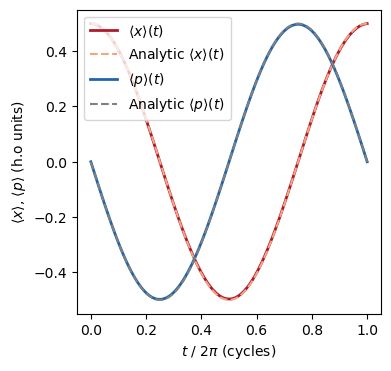

In [72]:
plot_expectation_values(X_grid, T_grid, psi_grid, dpsi_dx_grid, x0, folder_name=folder_name)

### Merging energy and expectation value plots

In [73]:
def plot_energy_and_expectations(X, T, psi, dpsi_dx, dpsi_dx2, x0, folder_name=None, title="energy_and_expectations"):
    """
    Plots stacked figures with:
    (1) Kinetic and potential energies (no total) + analytic expectation values for coherent state ω=1
    (2) Expectation values of position ⟨x⟩ and momentum ⟨p⟩ over time

    Parameters:
        X, T (torch.Tensor): Meshgrid tensors (Nx, Nt)
        psi (torch.Tensor): Complex wavefunction (Nx, Nt)
        dpsi_dx (torch.Tensor): First spatial derivative of psi (Nx, Nt)
        dpsi_dx2 (torch.Tensor): Second spatial derivative of psi (Nx, Nt)
        x0 (float): Coherent state displacement
        folder_name (str, optional): Folder path for saving plot
        title (str): Base filename for saving

    Returns:
        None
    """
    dx = (X[1,0] - X[0,0]).item()
    times = T[0, :].detach().cpu().numpy()
    times_rescaled = times / (2 * np.pi)

    kinetic_density = 0.5 * torch.real(torch.conj(psi) * (-dpsi_dx2))
    potential_density = 0.5 * (X**2) * torch.abs(psi)**2

    kinetic_energy = torch.trapz(kinetic_density, dx=dx, dim=0)
    potential_energy = torch.trapz(potential_density, dx=dx, dim=0)

    norm = torch.trapz(torch.abs(psi)**2, dx=dx, dim=0)
    kinetic_energy /= norm
    potential_energy /= norm

    kinetic_np = kinetic_energy.detach().cpu().numpy()
    potential_np = potential_energy.detach().cpu().numpy()

    kinetic_analytic = 0.25 + (x0**2 / 4) * (1 - np.cos(2 * times))
    potential_analytic = 0.25 + (x0**2 / 4) * (1 + np.cos(2 * times))

    density = torch.abs(psi)**2
    x_expectation = torch.trapz(X * density, dx=dx, dim=0)

    momentum_density = torch.conj(psi) * (-1j * dpsi_dx)
    p_expectation = torch.trapz(momentum_density, dx=dx, dim=0).real
    p_expectation /= norm

    x_expectation_np = x_expectation.detach().cpu().numpy()
    p_expectation_np = p_expectation.detach().cpu().numpy()

    x_analytic = x0 * np.cos(times)
    p_analytic = -x0 * np.sin(times)

    cmap = plt.get_cmap('RdBu')
    color_kinetic = cmap(0.1)
    color_potential = cmap(0.9)
    color_analytic_energy = cmap(0.3)

    color_x = cmap(0.1)
    color_p = cmap(0.9)
    color_analytic_xp = cmap(0.3)

    plt.rcParams.update({'font.size': 10})
    figsize = (5, 6)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # → Ticks normals a sota (com per defecte)
    # → Ja no cal afegir ticks a dalt ni eliminar etiquetes
    ax1.tick_params(axis='x', which='both', labelbottom=False)  # No mostrar valors de x a dalt
    ax2.tick_params(axis='x', which='both', top=False, bottom=True, labeltop=False, labelbottom=True)

    # --- Top plot: Energies ---
    ax1.plot(times_rescaled, kinetic_np, label="Kinetic", color=color_kinetic, lw=2)
    ax1.plot(times_rescaled, kinetic_analytic, '--', label="Analytic Kinetic", color=color_analytic_energy)
    ax1.plot(times_rescaled, potential_np, label="Potential", color=color_potential, lw=2)
    ax1.plot(times_rescaled, potential_analytic, '--', label="Analytic Potential", color="gray")

    ax1.set_ylabel("Energy (h.o. units)")
    ax1.legend(fontsize=8, loc="upper right")  # ← Fixem la llegenda a la cantonada dreta
    ax1.set_aspect(1. / ax1.get_data_ratio())
    ax1.set_ylim(0.24, 0.38)

    # --- Bottom plot: Expectation values ---
    ax2.plot(times_rescaled, x_expectation_np, label=r"$\langle x \rangle$", color=color_x, lw=2)
    ax2.plot(times_rescaled, x_analytic, '--', label=r"Analytic $\langle x \rangle$", color=color_analytic_xp)
    ax2.plot(times_rescaled, p_expectation_np, label=r"$\langle p \rangle$", color=color_p, lw=2)
    ax2.plot(times_rescaled, p_analytic, '--', label=r"Analytic $\langle p \rangle$", color="gray")

    ax2.set_ylabel(r"$\langle x \rangle$, $\langle p \rangle$ (h.o. units)")
    ax2.legend(fontsize=8, loc="upper right")  # ← Mateixa posició de llegenda
    ax2.set_aspect(1. / ax2.get_data_ratio())

    # Etiqueta d’eix x a sota (com demana)
    ax2.set_xlabel(r"$t / 2\pi$ (cycles)")
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    if folder_name:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{title}.pdf")

    plt.show()



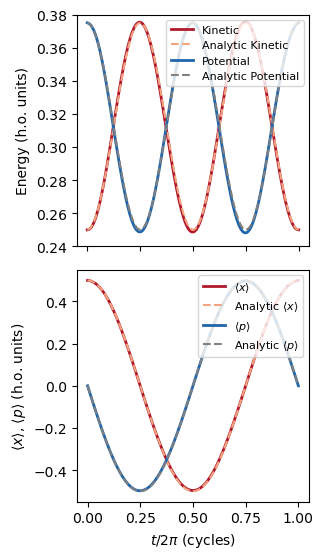

In [74]:
plot_energy_and_expectations(X_grid, T_grid, psi_grid, dpsi_dx_grid, dpsi_dx2_grid, x0, folder_name=folder_name, title="energy_and_expectations")

### Wavefunction components

The following figures show the predicted wavefunction over the spacetime grid:
- Real part
- Imaginary part
- Absolute value
- Relative error compared to the analytical solution

In [75]:
def plot_matrix(X, T, M, title="Matrix Visualization", folder_name=None, name='test'):
    """
    Plots a 2D matrix using a diverging colourmap and saves the plot if a folder is specified.

    Parameters:
        X, T (torch.Tensor): Meshgrid tensors of shape (Nx, Nt)
        M (array-like or torch.Tensor): 2D matrix of shape (Nx, Nt)
        title (str): Title of the colourmap and filename (default "Matrix Visualization")
        folder_name (str, optional): Folder path for saving the plot as a PDF
    """
    t_train = T[0, :]
    times = t_train.detach().cpu().numpy()
    times_rescaled = times / (2 * np.pi)
    x_train = X[:,0]
    x = x_train.detach().cpu().numpy()
    cmap = mpl.colormaps.get_cmap('RdBu')
    cmap.set_bad(color='green')
    vabs = np.abs(M).max()
    norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

    if hasattr(M, 'is_cuda') and hasattr(M, 'numpy'):
        M = M.detach().numpy()

    figsize = (4, 4)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    im = ax.pcolormesh(times_rescaled, x, M, cmap=cmap, shading='auto', norm=norm)

    plt.ylabel(r"x (h.o units)")
    plt.xlabel(r"$t$ $/$ $2\pi$ (cycles)")

    cbar = plt.colorbar(im)
    #cbar.set_label(title)
    plt.title(title)

    # Automatically format colorbar ticks to scientific if necessary
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Switch to scientific outside this range
    cbar.ax.yaxis.set_major_formatter(formatter)

    ax.set_aspect(1. / ax.get_data_ratio())

    pos_ax = ax.get_position()
    pos_cb = cbar.ax.get_position()
    cbar.ax.set_position([pos_cb.x0, pos_ax.y0, pos_cb.width, 1])
    plt.tight_layout()

    if folder_name is not None:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{name}.pdf", bbox_inches='tight')

    plt.show()


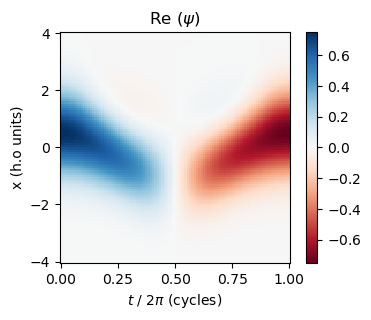

In [76]:
plot_matrix(X_grid, T_grid, psi_normalized.real.detach().numpy(), title = "Re ($\psi$)", name = "Re", folder_name=folder_name)

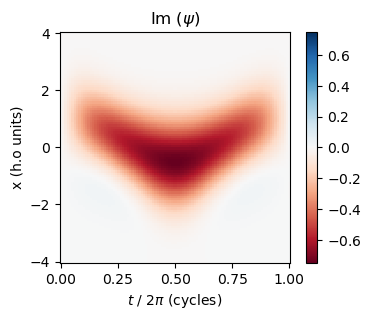

In [77]:
plot_matrix(X_grid, T_grid, psi_normalized.imag.detach().numpy(), title = "Im ($\psi$)", folder_name=folder_name, name = "Im")

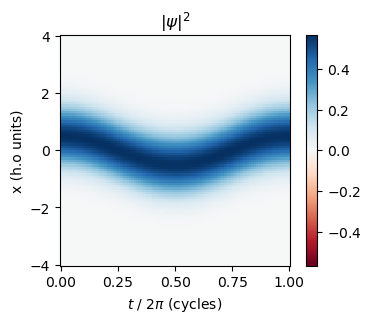

In [78]:
plot_matrix(X_grid, T_grid, psi_sq.detach().numpy(), title = "$|\psi|^2$", folder_name=folder_name, name = "Abs")

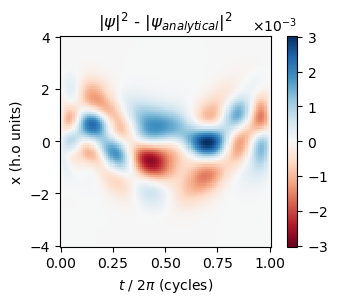

In [79]:
error=psi_sq-torch.abs(psi_analy)**2
plot_matrix(X_grid, T_grid, error.detach().numpy(), title = "$|\psi|^2$ - $|\psi_{analytical}|^2$", folder_name=folder_name, name = "error")

## Saving the data

### Saving model

This saves the trained model weights to file so that you can load them later without retraining. Execute this cell after training finishes to store the model.


In [80]:
torch.save(net.state_dict(), f"{folder_name}/{folder_name}_net.pth")

print(f"Saved neural network weights to {folder_name}_net.pth")

Saved neural network weights to 0.5_79873_0.01_40_40_100_2_net.pth


### Saving numerical results

This saves the computed numerical arrays (e.g., observables or wavefunctions) to `.npy` or `.txt` files for later analysis or plotting.

In [81]:
X_np = X_grid.detach().cpu().numpy()
T_np = T_grid.detach().cpu().numpy()
psi_np = psi_grid.detach().cpu().numpy()

np.savez(f"{folder_name}/{folder_name}", X=X_np, T=T_np, psi=psi_np, energy=energy, times=times_rescaled)

In [82]:
# === Prepare values ===
final_total_loss = losswcd_accum[-1]
final_tdse_loss = TDSE_accum[-1]
final_ini_loss = ini_accum[-1]
final_norm_loss = norm_accum[-1]
final_edges_loss = edges_accum[-1]
final_density_error = error.sum().item()
mean_density_error = error.mean().item()

# === Write to file ===
report_path = f"{folder_name}/{folder_name}_report.txt"

with open(report_path, "w") as f:
    f.write(f"Final Report for Run: {folder_name}\n")
    f.write("="*40 + "\n")
    f.write(f"Total Loss        : {final_total_loss:.6e}\n")
    f.write(f"TDSE Loss         : {final_tdse_loss:.6e}\n")
    f.write(f"Initial Cond Loss : {final_ini_loss:.6e}\n")
    f.write(f"Final Cond Loss   : {final_norm_loss:.6e}\n")
    f.write(f"Edges Loss        : {final_edges_loss:.6e}\n")
    f.write(f"Density Error     : {error.sum():.6e}\n")
    f.write(f"Mean Density Error: {error.mean():.6e}\n")
    f.write(f"Training Time     : {total_time/60:.2f} minutes \n")
    f.write(f"Overlap           : {overlap.item():.6e}\n")
    f.write(f"Mean Relative Energy Error: {mean_rel_error:.6e}\n")
    f.write(f"Max Relative Energy Error: {max_rel_error:.6e}\n")